In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods, txtbox512
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
from processing import tf_image
import cv2


In [2]:
isess = tf.InteractiveSession()

In [3]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    #print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

In [ ]:
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]
anchor_sizes=[(21., 51.),
              (51., 99.),
              (133., 153.),
              (215., 207.),
              (296., 261.),
              (379., 315.),
              (461, 543.)]
scale_range=[0.05, 0.75]
scale_range_max = [0.1, 0.9]
scales = [scale_range[0] + i*(scale_range[1] - scale_range[0])/6  for i in range(7)]
scales_max = [scale_range_max[0] + i*(scale_range_max[1] - scale_range_max[0])/6  for i in range(7)]
anchor_sizes = [(512*scales[i], 512*scales_max[i]) for i in range(7)]
anchor_sizes=[(30., 51.),
              (60., 99.),
              (114., 153.),
              (168., 207.),
              (222., 261.),
              (276., 315.)]

anchor_sizes



In [ ]:
math.sqrt(10)

text_shape (300, 300)
0.5
file_path: ../data/ICDAR2013/*.tfrecord


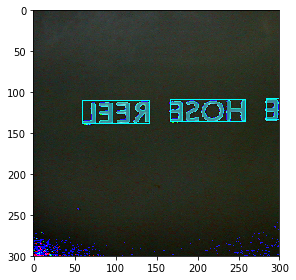

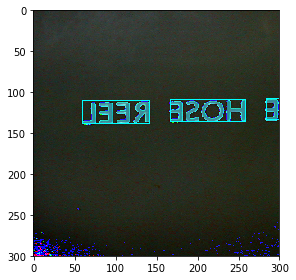

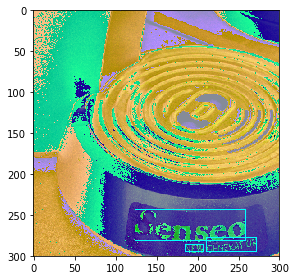

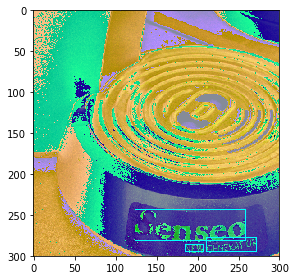

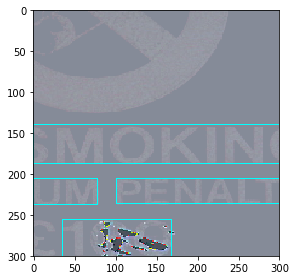

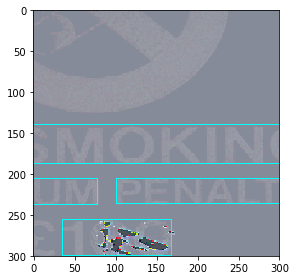

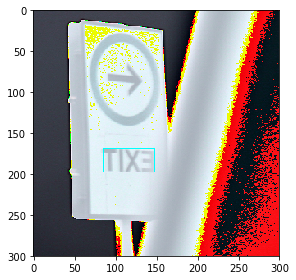

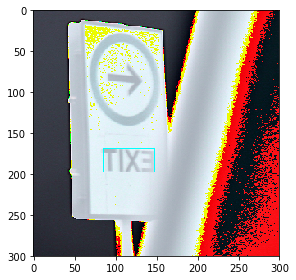

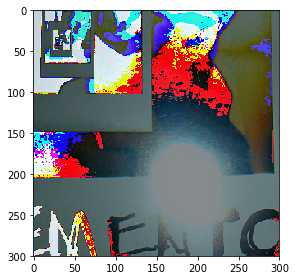

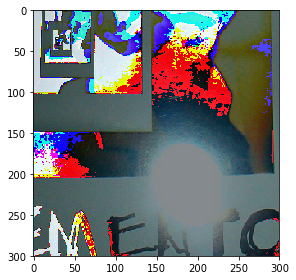

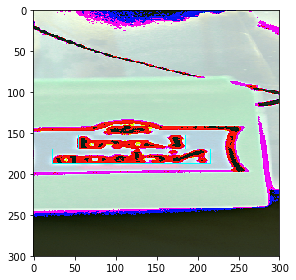

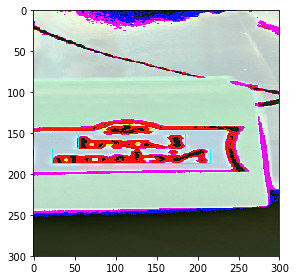

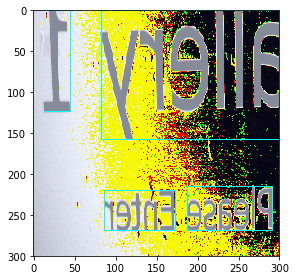

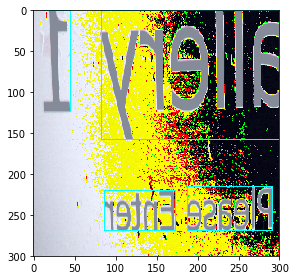

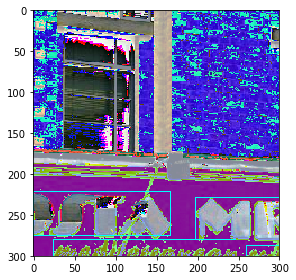

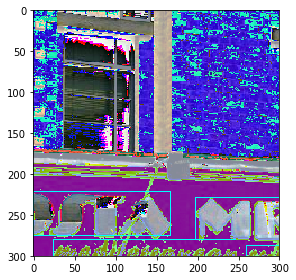

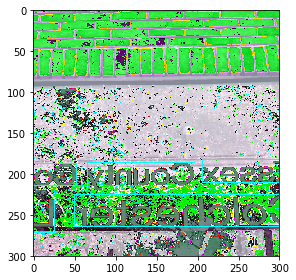

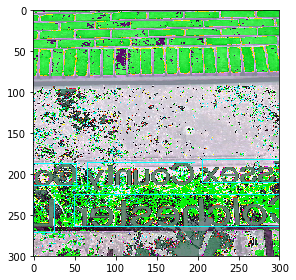

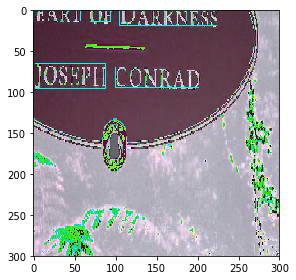

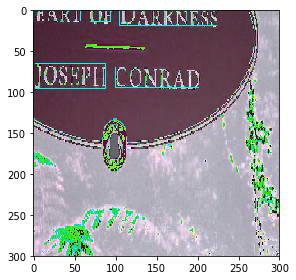

In [121]:
out_shape = [500,700]
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    
    #image = (dst_image - tf.reduce_min(dst_image))/ (tf.reduce_max(dst_image) - tf.reduce_min(dst_image))
    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    logits = []
    predictions = []
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
        logits.append(tf.cast(gscores[i] > 0.5, tf.int32))
        predictions.append(tf.one_hot(logits[i],axis=-1,depth=2,off_value=0.0,on_value=1.0))
    localisations = text_net.bboxes_decode(glocalisations, text_anchors)
    rscores, rbboxes = \
    text_net.detected_bboxes(predictions, localisations,
                            select_threshold=0.01,
                            nms_threshold=0.5,
                            clipping_bbox=None,
                            top_k=400,
                            keep_top_k=400)
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            error = []
            box = []
            ws = []
            hs = []
            for i in xrange(10):
                rpredictions, rlocalisations, img ,gbboxes_, pre_box_= \
                                        sess.run([gscores, glocalisations,dst_image,gbboxes,rbboxes])
                error.append(gbboxes_)
                img = img * 255
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                img_ = image_.copy()
                visualize_bbox(img_, pre_box_[1][0])

In [ ]:
[(hs[i]*300, (ws[i]/hs[i])**2) for i in range(len(hs)) if hs[i] < 30./300]

In [56]:
whratio = [(ws[i]/hs[i])**2 for i in range(len(hs)) if hs[i] < 30./300]
np.histogram(whratio, bins=1000)[1][:25]

array([ 0.03263778,  0.27497713,  0.51731649,  0.75965584,  1.00199519,
        1.24433454,  1.48667389,  1.72901324,  1.97135259,  2.21369194,
        2.45603129,  2.69837064,  2.94070999,  3.18304934,  3.42538869,
        3.66772805,  3.9100674 ,  4.15240675,  4.3947461 ,  4.63708545,
        4.8794248 ,  5.12176415,  5.3641035 ,  5.60644285,  5.8487822 ])

In [106]:
yref, xref, href, wref = text_anchors[0]
ymin = yref - href / 2.
xmin = xref - wref / 2.
ymax = yref + href / 2.
xmax = xref + wref / 2. 
vol_anchors = (xmax - xmin) * (ymax - ymin)
vol_anchors 

array([[[[ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
           0.01      ],
         [ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01000001,
           0.01      ]],

        [[ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
           0.01      ],
         [ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01000001,
           0.01      ]],

        [[ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
           0.01      ],
         [ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01000001,
           0.01      ]],

        ..., 
        [[ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
           0.01      ],
         [ 0.01      ,  0.00999999,  0.01000001,  0.01      ,  0.01      ,
           0.01      ]],

        [[ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
           0.01      ],
         [ 0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01000001,
           0

In [85]:
np.sqrt(0.004)*300

18.973665961010276

In [ ]:
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            box = []
            for i in xrange(5000):
                gbboxes_= sess.run([gbboxes])
                leng = gbboxes_[0][:,2] - gbboxes_[0][:,0]
                box.append(leng)


In [ ]:
boxes = [i.tolist() for i in box]

In [ ]:
all_box = []
combined = [item*300 for sublist in boxes for item in sublist]

In [ ]:
import numpy 

hist,bins=np.histogram(combined,bins=np.linspace(0,300,60))
print(hist,bins)

In [ ]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions_2[i] > 0.5)].shape

In [ ]:
gbboxes_[0].shape

In [ ]:
import math
min_dim = 300
min_ratio = 20
max_ratio = 95
step = int(math.floor((max_ratio - min_ratio) / (6 - 2)))
min_sizes = []
max_sizes = []
for ratio in xrange(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 10 / 100.] + min_sizes
max_sizes = [[]] + max_sizes

In [ ]:
np.savetxt(fname='result.csv',X=a,delimiter=',',fmt='%.4f')

In [ ]:
max_sizes

In [ ]:
anchor_sizes